# 1.    Setup the environment 

Pandas,Numpy for data manuplation.
Matplotlib,seaborn module for Data Visualisation. 

sklearn for data preparing and clustering

scipy for creating dendrogram

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

import sklearn.metrics as metrics
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
from sklearn.metrics import silhouette_score


# 2. Load the data

In [2]:

fn ='C:\\Users\\Keerthi\\Desktop\\Jigsaw\\10 UC-Advance Analytics & Machine Learning\\02-Assignment\\WEEK-4\\company_stocks.csv'
stocks = pd.read_csv(fn, index_col=0)

companies = list(stocks.index)
stocks.head()

,4/1/2010,5/1/2010,6/1/2010,7/1/2010,8/1/2010,11/1/2010,12/1/2010,13/1/2010,14/1/2010,15/1/2010,...,16/10/2013,17/10/2013,18/10/2013,21/10/2013,22/10/2013,23/10/2013,24/10/2013,25/10/2013,28/10/2013,29/10/2013
AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,-0.709999,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998
Bank of America,0.450000,0.460001,0.180000,0.250000,-0.199999,-0.060000,-0.359998,0.190001,0.190001,-0.379999,...,0.240000,0.210000,-0.050000,-0.010000,-0.030000,-0.240000,0.050000,0.110000,-0.060000,-0.110000
Canon,0.730000,0.369999,-0.099999,-0.169999,0.030003,0.110001,-0.079998,0.140000,0.389999,-0.130001,...,0.209999,0.560002,0.069999,0.119999,0.050003,-0.459999,0.259998,-0.109999,0.090001,-0.110001


## Plotting the data

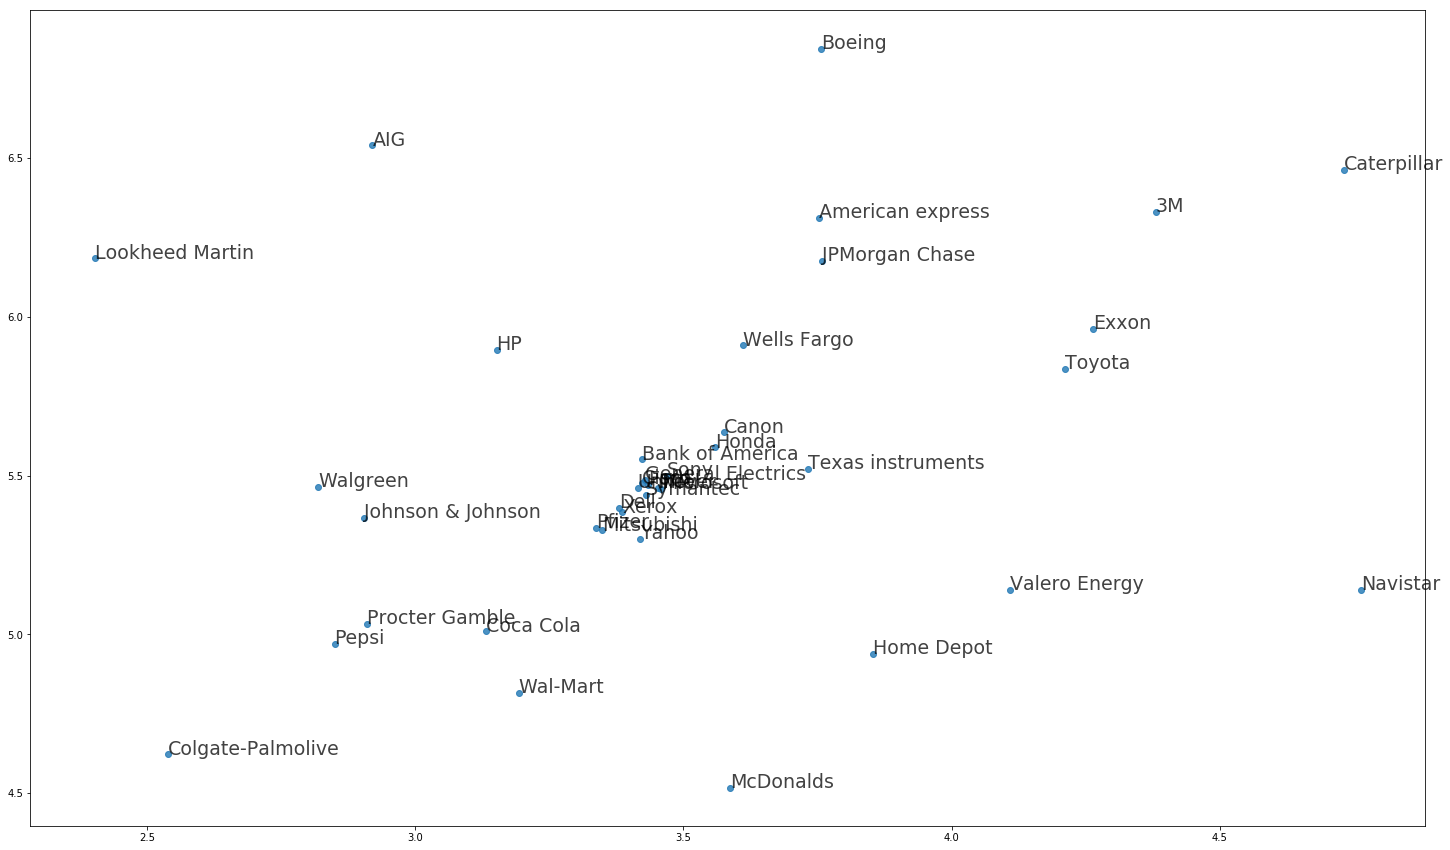

In [3]:
# Import TSNE t-SNE provides great visualizations when the individual samples can be labeled.
from sklearn.manifold import TSNE
model = TSNE(learning_rate=50)
tsne_features = model.fit_transform(stocks)
xs = tsne_features[:,0]
ys = tsne_features[:,1]

# Scatter plot
plt.figure(figsize=(25,15))
plt.scatter(xs, ys, alpha=.8)
# Annotate the points
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=19, alpha=2.75)
plt.show()

### Observations

    We can observe that some of the companies are exhibiting same kind of trading behaviour over 2010-2013 period. Let's check the clustering of those companies using Aggloremative clustering.


### 3.Data preprocessing-Missing values

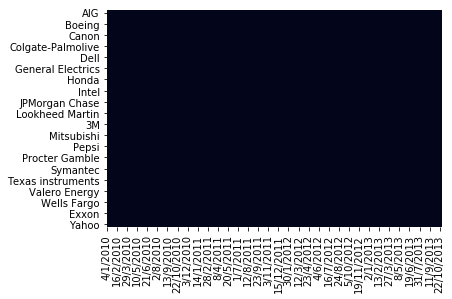

In [4]:
sns.heatmap(stocks.isnull(), cbar=False)

In [5]:
print('Data Dimension-->',stocks.shape)

Data Dimension--> (39, 963)



    We observe that there are 963 dimension which is not possible or not an good idea for clustering.
    
    The data consists of the price devation of stock in a day and it further spans to 3years starting from 4/1/2010. 
    
    The clustering of companies is based on
        
        1)  Direction of change in stock value in a day
        
        2)  Magnitude of change in stock value in a day 
    
            Direction of change in stock value in a day : The sign of average change over the period of time is used to define the direction of the stock price.
                    0 --> if the averge change in stock price is <= 0 
                    1 --> otherwise.
                    
                    Given the binary categories , the data is splitted into two clusters based on the direction of the change. Further for each category new clusters will be explored based on magnitude of the change.
                    
             Magnitude of change : The variance of the stock price of time series data for each company is considered as a metric to group the companies based on the magintude of change in stock price .
    

                    

# 3. Dimension Reduction

In [6]:
from statistics import variance 
stocks['Variance'] = stocks.var(axis=1)
stocks['Average']=stocks.median(axis=1)
       

In [7]:
def profit(x) :
    if x>0 :
        return 1
    else :
        return 0
    
stocks['Direction'] = stocks['Average'].apply(profit)

In [8]:
#Selecting data with positive direction i.e above the mean

stocks_temp=stocks.loc[(stocks['Direction'] == 1 ) ]
print('Number of companies in positive -->', stocks_temp.shape)
stocks_positive= stocks_temp[['Variance']]
companies_p = list(stocks_positive.index)



#Selecting data with negative direction i.e below the mean

stocks_temp=stocks.loc[(stocks['Direction'] == 0 ) ]
print('Number of companies in negative -->', stocks_temp.shape)
stocks_negative= stocks_temp[['Variance']]
companies_n = list(stocks_negative.index)


Number of companies in positive --> (30, 966)
Number of companies in negative --> (9, 966)


## 4. Inspect the first few rows of the DataFrames by calling its head() function.

In [9]:
print(stocks_positive.head())
print(stocks_negative.head())

                   Variance
American express   0.460744
Boeing             0.897603
Canon              0.131478
Caterpillar        1.529400
Colgate-Palmolive  0.540033
                   Variance
AIG                0.629885
Bank of America    0.049768
Cisco              0.059639
Ford               0.048166
General Electrics  0.048428


# 5. 	Clustering – Hierarchical / Aggloremative clustering

In [10]:
mergings_ward_p = linkage(stocks_positive, method='ward', metric='euclidean')
mergings_ward_n = linkage(stocks_negative, method='ward', metric='euclidean')

    The function called linkage, so this essentially builds our hierarchical clustering model.
     Calculating the euclidean distances between a cluster and a point or a point and a cluster or a cluster or a cluster,we are using 'ward' method.
     

# 6. Plot a dendogram: Positive Direction

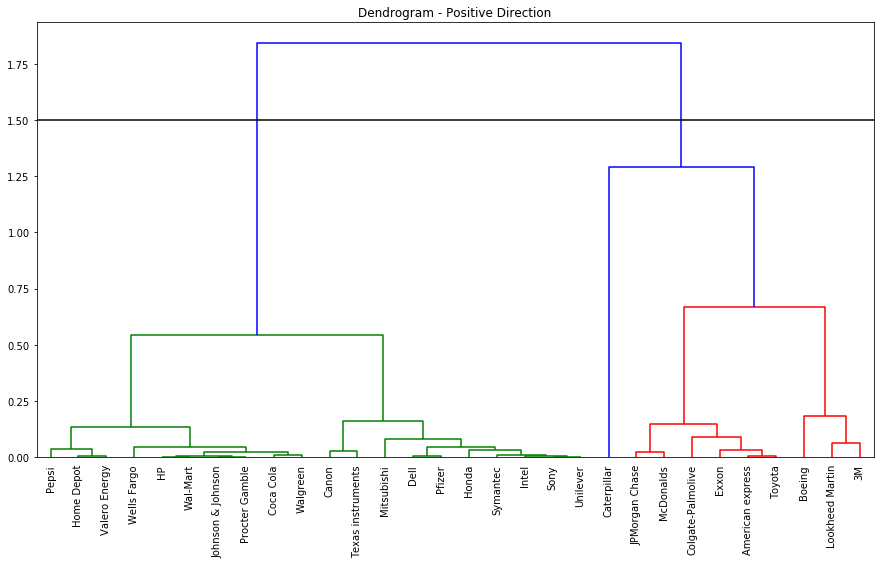

<Figure size 7200x18000 with 0 Axes>

In [11]:
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 15 
fig_size[1] = 8 
plt.rcParams["figure.figsize"] = fig_size 

fig, ax = plt.subplots()
dendrogram(
    mergings_ward_p,
    labels=companies_p,
    leaf_rotation=90,
    leaf_font_size=10
)
threshold = 1.5 #for hline
ax.axhline(y=threshold, c='k')
plt.title('Dendrogram - Positive Direction')
plt.figure(figsize=(100, 250))
plt.show()



### Observations

We can visually see that at euclidean distance of 1.5 we can segement into two clusters .

### Silhouette scores. 

In [13]:
agg_labels_positive=AgglomerativeClustering(n_clusters=2).fit(stocks_positive).labels_
silhouette_score(stocks_positive,agg_labels_positive,metric="euclidean")

0.5857101131570575

### Observation

The silhouette_score is optimally good  

# 7. Plot a dendogram: Negative Direction

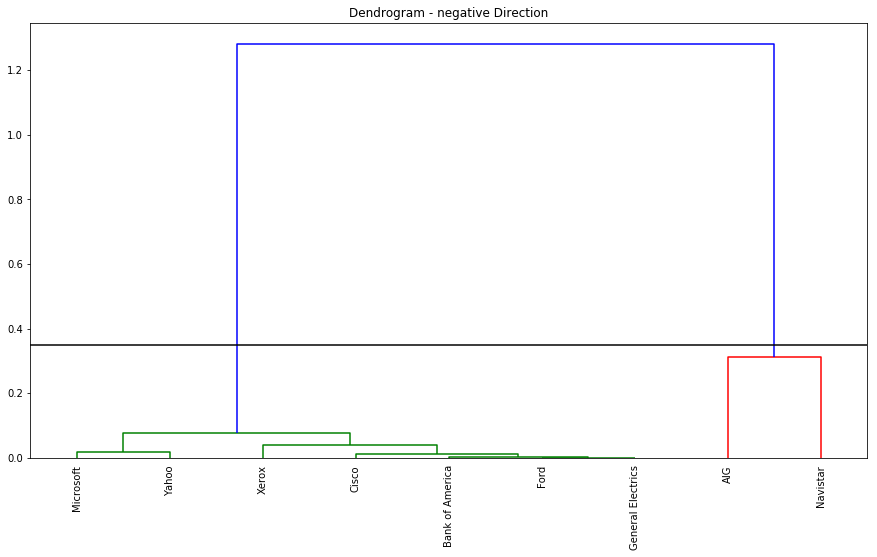

<Figure size 7200x18000 with 0 Axes>

In [14]:
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 15 
fig_size[1] = 8 
plt.rcParams["figure.figsize"] = fig_size 

fig, ax = plt.subplots()
dendrogram(
    mergings_ward_n,
    labels=companies_n,
    leaf_rotation=90,
    leaf_font_size=10
)
threshold = 0.35 #for hline
ax.axhline(y=threshold, c='k')
plt.title('Dendrogram - negative Direction')
plt.figure(figsize=(100, 250))
plt.show()



### Observations


We can visually see that at euclidean distance of 0.35 we can segement into two clusters .

### Silhouette scores. 

In [15]:
agg_labels_negative=AgglomerativeClustering(n_clusters=2).fit(stocks_negative).labels_
silhouette_score(stocks_negative,agg_labels_negative,metric="euclidean")

0.8677945769474166

### Observation

The silhouette_score is optimally good  

# (8) Building agglomerative clustering with  optimal Clusters= 2 for both directions

In [16]:
model_p = AgglomerativeClustering(n_clusters=2)
model_p.fit(stocks_positive)
agg_labels_positive =model_p.labels_
agg_labels_positive[:40]


array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [17]:
model_l = AgglomerativeClustering(n_clusters=2)
model_l.fit(stocks_negative)
agg_labels_negative =model_l.labels_
agg_labels_negative[:40]

array([0, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

# 9) Boundaries- Comparing Original data & Cluster data

Text(0.5, 1.0, 'Clusterd Data- Negative Direction')

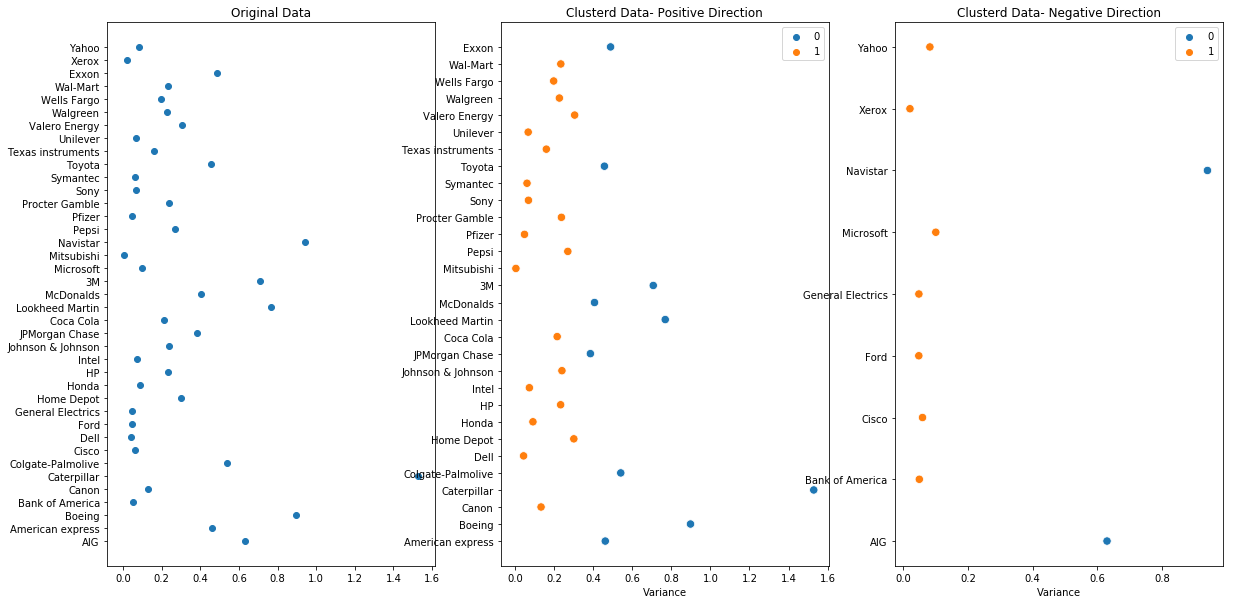

In [20]:
import seaborn as sns
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.scatter(stocks['Variance'],y=companies)
plt.title('Original Data')
plt.subplot(1, 3, 2)
sns.scatterplot(stocks_positive['Variance'],companies_p,  hue=agg_labels_positive, s=70)
plt.title('Clusterd Data- Positive Direction')
plt.subplot(1, 3, 3)
sns.scatterplot(stocks_negative['Variance'],companies_n,  hue=agg_labels_negative, s=70)
plt.title('Clusterd Data- Negative Direction')


### Observations

    For Positive direction Data:
            Cluster 1: Variance >0.4 and companies in positive direction
            Cluster 2: Variance < 0.4 and companies in Positive direction
            
    For Negative direction Data:
            Cluster 1: Variance >0.4 and companies in Negative direction
            Cluster 2: Variance < 0.4 and companies in Negative direction

# (10) Partition of companies into clusters

In [28]:
predictions_positive = np.where(agg_labels_positive==0, "Cluster- 1 : Variance >0.4 in positive direction","Cluster - 2 : Variance < 0.4 in Positive direction")
predictions_positive_no = np.where(agg_labels_positive==0, 0,1)

predictions_negative = np.where(agg_labels_negative==0, "Cluster - 3 : Variance >0.4 in Negative direction","Cluster - 4 :Variance < 0.4 in Negative direction")
predictions_negative_no = np.where(agg_labels_negative==0, 0,1)

cluster= pd.Series(predictions_positive)

stocks_positive_cluster=stocks_positive.assign( Cluster = predictions_positive)



cluster= pd.Series(predictions_negative)
stocks_negative_cluster=stocks_negative.assign(Cluster = predictions_negative)

print(stocks_negative_cluster.head())
print(stocks_positive_cluster.head())

                   Variance                                            Cluster
AIG                0.629885  Cluster - 3 : Variance >0.4 in Negative direction
Bank of America    0.049768  Cluster - 4 :Variance < 0.4 in Negative direction
Cisco              0.059639  Cluster - 4 :Variance < 0.4 in Negative direction
Ford               0.048166  Cluster - 4 :Variance < 0.4 in Negative direction
General Electrics  0.048428  Cluster - 4 :Variance < 0.4 in Negative direction
                   Variance                                            Cluster
American express   0.460744   Cluster- 1 : Variance >0.4 in positive direction
Boeing             0.897603   Cluster- 1 : Variance >0.4 in positive direction
Canon              0.131478  Cluster - 2 : Variance < 0.4 in Positive direc...
Caterpillar        1.529400   Cluster- 1 : Variance >0.4 in positive direction
Colgate-Palmolive  0.540033   Cluster- 1 : Variance >0.4 in positive direction


In [26]:
frames = [stocks_positive_cluster, stocks_negative_cluster]

result = pd.concat(frames)
result.drop(['Variance'],axis=1)


,Cluster
American express,Cluster- 1 : Variance >0.4 in positive direction
Boeing,Cluster- 1 : Variance >0.4 in positive direction
Canon,Cluster - 2 : Variance < 0.4 in Positive direc...
Caterpillar,Cluster- 1 : Variance >0.4 in positive direction
Colgate-Palmolive,Cluster- 1 : Variance >0.4 in positive direction
Dell,Cluster - 2 : Variance < 0.4 in Positive direc...
Home Depot,Cluster - 2 : Variance < 0.4 in Positive direc...
Honda,Cluster - 2 : Variance < 0.4 in Positive direc...
HP,Cluster - 2 : Variance < 0.4 in Positive direc...
Intel,Cluster - 2 : Variance < 0.4 in Positive direc...
